# Severity Distribution of a Score: HighRiskCustomerContinuous

In [1]:
from pyspark.sql.functions import *
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
SCORE_OUTPUT_ROOT="gs://green-1-accelerators-1-username-dpr-stg-bucket/scoring/"
FILE_PATH="Document/AdditionalOutput/HighRiskCustomerContinuous"
STATISTICS_PATH = "Document/Statistics/Customer_CustomerScoreOutput_Merged_ScoreStatistics"
SCORE_ID_OF_INTEREST="HighRiskCustomerContinuous"

Read in the score from the AdditionalOutput folder and the score statistics from the Customer_CustomerScoreOutput_Merged_ScoreStatistics data.

In [3]:
df = spark.read.parquet(SCORE_OUTPUT_ROOT+FILE_PATH)

In [4]:
statistics = spark.read.parquet(SCORE_OUTPUT_ROOT+STATISTICS_PATH)

Expand the customOutput column and convert to pandas dataframe.

In [5]:
score_output = df.select("subject","customOutput.*")

In [6]:
score_output.show(5,False)

+-----------+-------------+--------+----+--------------------------------------------------+
|subject    |keys         |severity|band|description                                       |
+-----------+-------------+--------+----+--------------------------------------------------+
|10092942152|[10092942152]|20      |null|High risk customer Harry Krichauff (10092942152). |
|10910136667|[10910136667]|100     |null|High risk customer Matthew Tremper (10910136667). |
|45613094600|[45613094600]|100     |null|High risk customer Jimmy Bennett (45613094600).   |
|47583858045|[47583858045]|26      |null|High risk customer Enrique Voss (47583858045).    |
|56413973236|[56413973236]|35      |null|High risk customer Campbell Rochele (56413973236).|
+-----------+-------------+--------+----+--------------------------------------------------+
only showing top 5 rows



In [10]:
score_output_pd = score_output.toPandas()

Get total number of customers.

In [8]:
num_cust=statistics.filter(col("scoreId")==SCORE_ID_OF_INTEREST).select("totalInputs").head()[0]

### Analysing severity distribution

Look at the number of times each severity occurs and plot histogram.

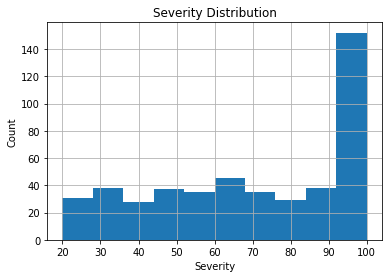

In [11]:
score_output_pd["severity"].hist()
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

Modify the number of bins.

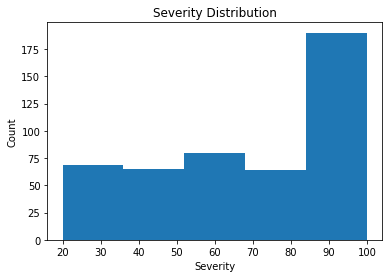

In [12]:
num_bins = 5
n, bins, patches = plt.hist(score_output_pd["severity"], bins=num_bins)
plt.title("Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()
plt.show()

Get number of customers who don't trigger a score.

In [15]:
count_triggers = statistics.filter(col("scoreId")==SCORE_ID_OF_INTEREST).select("countTriggers").head()[0]
no_triggers = num_cust-count_triggers
no_triggers_rate = 100*float(no_triggers)/num_cust

Calculate trigger rates for bins.

In [36]:
severity_rates_pd=pd.DataFrame({'severity_lower_bound':bins[0:num_bins], 'count':n, 'trigger_rate (%)':100*n/num_cust})
no_triggers_row = pd.DataFrame({'severity_lower_bound':0.0, 'count':no_triggers, 'trigger_rate (%)':no_triggers_rate},index=[0])
severity_rates_appended_pd = no_triggers_row.append(severity_rates_pd,ignore_index=True)

In [38]:
severity_rates_appended_pd

,severity_lower_bound,count,trigger_rate (%)
0,0.0,1532.0,76.60
1,20.0,69.0,3.45
2,36.0,65.0,3.25
3,52.0,80.0,4.00
4,68.0,64.0,3.20
5,84.0,190.0,9.50


About 25% of customers trigger a score. The severities are quite evenly spread from 20-90 and then there are a large number of people with severities close to 100.